# Cooperation in Repeated Prisoner's Dilemma Games
## *Alex Matters*
**December 15, 2016**

Abstract:
The Prisoner's Dilemma is a game used in experimental economics to study the tension between individual incentives and group benefit in strategic situations. This notebook uses a meta data set originally compiled by Guillaume Frechette and Dal Bo (2016) to explore factors that affect cooperation rates. In particular, the continuation probability (ie. discount factor) $\delta$ and parameters related to the relative payoffs of defecting and cooperating are graphed as predictors of cooperation. I show that cooperation rates are positively effected by the probability $\delta$ of partners meeting in a future round, and that three more nuanced measures of the "difficulty of cooperation" proposed by the paper's original authors are all good predictors of differential cooperation rates.

## Preliminaries
Import the required packages and check that all versions are up to date.

In [1]:
import sys                             # system module 
import pandas as pd                    # data package
import matplotlib.pyplot as plt        # graphics module  
import datetime as dt                  # date and time module
import numpy as np                     # foundation for Pandas
from IPython.display import Image
from IPython.core.display import HTML  # display images in the notebook

%matplotlib inline                     

# check versions
print('Python version:', sys.version)
print('Pandas version: ', pd.__version__)
print('Today: ', dt.date.today())

Python version: 3.5.2 |Anaconda 4.2.0 (x86_64)| (default, Jul  2 2016, 17:52:12) 
[GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)]
Pandas version:  0.19.0
Today:  2016-12-22


## The Data Source
### **Frechette & Bo's *On the Determinants of Cooperation in Infinitely Repeated Games: A Survey***

This data set comes from a survey paper of recent work in experimental economics exploring cooperation in Prisoner's Dilemma games. For the paper, which is yet to be published, Guillaume Frechette (NYU) and Dal Bo (Brown University) aggregate a total of 157,170 choices from 15 papers published over the last 15 years into one data set. The data set is publically available on professor Frechette's [personal website](http://cess.nyu.edu/frechette/html/papers.htm). The full paper can be obtained [here](http://cess.nyu.edu/frechette/print/Dal_Bo_2016a.pdf).

Below I import and display the first and last few lines of the data set to verify it is in a workable form. Adjustments are made to exclude the first 31 rows of the document (which provide the column definitions), to denote that the file uses tab separators, and to import only certain columns that will be useful in this exploration.

In [2]:
# web address where the data set for Frechette and Bo (2016) is stored
url = 'http://cess.nyu.edu/frechette/data/Dal_Bo_2016a_data.txt'

coop = pd.read_csv(url,
                  sep = '\t',                  # denote the separator in the data file is tab
                  skiprows = 31,               # the first 31 rows of the file are the legend
                  usecols =                    # specify columns of interest
                   ['paper', 'supergame', 'round', 'g', 'l', 'delta', 'sgpe', 'rd', 'coop', 'sizeBAD'])

In [3]:
coop.head(6) # display the first rows the dataFrame to see it is in a workable format

,paper,supergame,round,g,l,delta,sgpe,rd,sizeBAD,coop
0,Andreoni and Miller 1993,1,1,1.666667,1.333333,0.0,0,0,1.0,coop
1,Andreoni and Miller 1993,2,1,1.666667,1.333333,0.0,0,0,1.0,defect
2,Andreoni and Miller 1993,3,1,1.666667,1.333333,0.0,0,0,1.0,defect
3,Andreoni and Miller 1993,4,1,1.666667,1.333333,0.0,0,0,1.0,defect
4,Andreoni and Miller 1993,5,1,1.666667,1.333333,0.0,0,0,1.0,defect
5,Andreoni and Miller 1993,6,1,1.666667,1.333333,0.0,0,0,1.0,defect


In [5]:
coop.tail(6) # final rows of the DataFrame

,paper,supergame,round,g,l,delta,sgpe,rd,sizeBAD,coop
157164,Dal Bo and Frechette 2015,5,37,2.571429,1.857143,0.95,1,1,0.101562,defect
157165,Dal Bo and Frechette 2015,5,38,2.571429,1.857143,0.95,1,1,0.101562,defect
157166,Dal Bo and Frechette 2015,5,39,2.571429,1.857143,0.95,1,1,0.101562,defect
157167,Dal Bo and Frechette 2015,5,40,2.571429,1.857143,0.95,1,1,0.101562,defect
157168,Dal Bo and Frechette 2015,5,41,2.571429,1.857143,0.95,1,1,0.101562,defect
157169,Dal Bo and Frechette 2015,5,42,2.571429,1.857143,0.95,1,1,0.101562,defect


We see that the data set has been successfully imported, though the meaning of some variables in their current form are likely to be unclear to a reader who has not also read Frechette and Bo's paper. We will clarify these variables and do some other cleaning soon, but first it will be helpful to introduce a description and some theory about the Prisoner's Dilemma itself. Readers familiar with the topic may want to skip over some of this explanatory section.

## The Prisoner's Dilemma: A Brief Introduction
In game theory and experimental economics, a game refers to an interaction between two or more players in which an interaction of the choices made by each player determines a final outcome. These outcomes are quantified by payoffs, which are meant to represent how each player values the results and their preferences between them (these can be thought of as utility, money, happiness, etc.).

The Prisoner's Dilemma is a simple, important and famous game in the field that has been studied and found broad application across an array of fields including market competition, military strategy, advertising, diplomatic relations and evolutionary biology. It is structured so that two players simultaneously choose one of two options, which we deem 'cooperate' and 'defect'; what makes the game interesting and applicable in so many settings is that both players have an individual incentive to choose defect in order to increase their personal payoff, yet if both players choose to defect they end up worse off than if they would have each chosen to cooperate.

The table below represents the payoff to each player given their individual choices. The first letter in each tuple represents the payoff to 'you', while the second is the payoff of 'your buddy'.

In [6]:
pris_image = 'https://www.learner.org/courses/mathilluminated/images/units/9/1198.png'
Image(url = pris_image, width = 600, height = 500)
# This image is taken from the free online course 'MATHematics Illuminated' provided by Annenberg Learner
# at the address above.

The variables in the payoff matrix can be interpreted as follows:
- R ('reward') - the payoff, larger then P, players receive for managing to cooperate
- T ('temptation') - the greatest payoff, even larger than R, providing a personal incentive for deviation from the cooperative outcome
- P ('punishment') - the payoff, less than R, that players receive when they both defect
- S ('sucker's payoff') - the lowest payoff, which a player receives when they cooperate but their partner defects

A two player simultaneous game of this structure qualifies as a Prisoner's dilemma when
$T > R > P > S$ and $T + S < 2 * R$. The first condition ensures there is always a dominating personal incentive for a player to defect to increase their own payoff, while the second condition is more technical, stipulating that alternating between defecting on one another in successive rounds (if the players managed to coordinate such a feat) would not be a more profitable strategy.

Game theory predicts that in all one-shot prisoner's dilemmas (ie. two agents play the game above and never interact again), there should be a 100% defection rate as it is the dominant strategy, meaning that defection leaves each player with the highest possible payoff given his opponent's choice, regardless of what that choice is. However, in experiments a rate of cooperation greater than zero is consisently observed. Furthermore, when the game is played repeatedly (or with some probability of a subsequent round of play), it is generally predicted that cooperation rates will rise as players have an incentive to "play nice". We aim to explore the factors contributing to this phenomenon here.

## Preparing and Exploring the Data
First, we clean the dataframe and explain the meaning of the variables, renaming where it provides greater clarity.

The first three variables identify the context in which the observation was made. **Paper** gives the year and authors' surname of the original source of the data. **Round** refers to the round of the game played with the same partner. For example, round = 5 indicates this is the fifth time in a row the chosen subject has played the prisoner's dilemma with the same partner, while round = 1 indicates she has just started with a new partner.

In [7]:
print('Minimum Rounds:', coop['round'].min(), '\nMaximum rounds:', coop['round'].max())

Minimum Rounds: 1 
Maximum rounds: 69


We can see above that a pair of participants play anywhere between a single one-shot round of the prisoner's dilemma up to 69 rounds in a row without changing partners. One set of games with a single partner is referred to as a supergame, such that the **supergame** variable indicates the observation is for a person playing with their first, second, third, etc. partner since starting the experiment.

The **delta** ($\delta$) variable is helpful in explaining why the lengths of the supergames vary so much, and we will use it to help explain cooperation rates. $\delta$ is the probability a pair of players will play another round of the game with each other, helping to simulate 'infinite' or at least indefinite play. The closer $\delta$ is to 1, the greater the likelihood play will continue; this random element in determining whether play will continue is what makes the supergames of such varying lengths.

Below we rename the variable to match Frechette and Bo's notation and observe that the values of $\delta$ in our data set vary from 0.00 (one-shot game) to 0.95 (95% chance the game will continue after each round). The median observation in the entire data set is a round with a 75% probability of further play, equivalent to a supergame which lasts an mean length of 4 rounds.

In [8]:
coop = coop.rename(columns = {'delta' : '$\delta$'})
coop['$\delta$'].describe()

count    157170.000000
mean          0.683515
std           0.233491
min           0.000000
25%           0.500000
50%           0.750000
75%           0.800000
max           0.950000
Name: $\delta$, dtype: float64

The string variable **coop** denotes whether the player chose to cooperate or defect, which will be our dependent (y) variable of interest. We convert it now to a binary integer ('**cooperate**') with 1 representing cooperation, allowing us to calculate cooperation rates later on.

In [9]:
# we create a dictionary and use the map command to convert cooperative choices to 1s
# and defections to 0s, then drop the original `coop` variable, as it is no longer needed
cooperateInt = {'coop' : 1, 'defect' : 0}
coop['cooperate'] = coop['coop'].map(cooperateInt)
coop = coop.drop('coop', axis=1)
coop.head()

,paper,supergame,round,g,l,$\delta$,sgpe,rd,sizeBAD,cooperate
0,Andreoni and Miller 1993,1,1,1.666667,1.333333,0.0,0,0,1.0,1
1,Andreoni and Miller 1993,2,1,1.666667,1.333333,0.0,0,0,1.0,0
2,Andreoni and Miller 1993,3,1,1.666667,1.333333,0.0,0,0,1.0,0
3,Andreoni and Miller 1993,4,1,1.666667,1.333333,0.0,0,0,1.0,0
4,Andreoni and Miller 1993,5,1,1.666667,1.333333,0.0,0,0,1.0,0


The other factor will will investigate as influencing cooperation rates is the relative differences in the payoffs, which we saw represented above as T, R, P, and S. However, it can be difficult to compare experiments which may vary on these four different paramenters, especially when the stakes make be uniformly higher or lower in any given experimental design. It turns out these differences can be summarized into just two standardized ratios, which are included in our data set:
- **g**, the relative gain from defecting on a cooperative partner, and
- **l**, the relative loss of having a partner defect when you cooperate

The table below outlines the normalizing transformation to create these measures, found on [page 5](http://cess.nyu.edu/frechette/print/Dal_Bo_2016a.pdf) of Frechette and Bo's paper.

In [10]:
Image(url = 'http://oi67.tinypic.com/126af0p.jpg')

In [11]:
print('Mean l:', coop['l'].mean(), '\t\tMin l:', coop['l'].min(), '\t\tMax l:', coop['l'].max())
print('Mean g:', coop['g'].mean(), '\t\tMin g:', coop['g'].min(), '\t\tMax g:', coop['g'].max())

Mean l: 1.1666822050143209 		Min l: 0.11111111 		Max l: 8.0
Mean g: 1.223387308298461 		Min g: 0.08695652 		Max g: 2.5714286


Above we quickly summarize the mean and range of the gain and loss variables to gain a sense of how they vary.

The variable labelled '**sgpe**' is a binary integer and stands for *subgame perfect equilibrium*. In game theory a profile of strategies is considered to be in equilibrium if each player is maximizing their benefit or preferences in light of the other's strategy. We will not fully explain subgame perfect equilibrium or how to determine it here, but it is useful to know that in repeated games ($\delta \geq 0$) we can calulate whether strictly rational players have an incentive to cooperae in equilibrium. A value of 1 indicates cooperation is supported as an equilibrium strategy. As previously established, this will never be the case when $\delta = 0$, which is confirmed by looking at the first few values below, where $\delta$ is zero. We rename the variable **Subgame Perfect** for added clarity.

Similarly, '**rd**' stands for risk dominant. A second approach to predicting a player's action in game theory determines the *risk dominant* equilibrium. This approach assumes the player is sensitive to potential losses (in this case, being defected on by one's partner) and determines whether the player would be rationally justified to defect or cooperate in light of uncertainty about his or her partner's choice. We rename the variable **Risk Dominant**.

In [12]:
coop = coop.rename(columns = {'sgpe': 'Subgame Perfect', 'rd': 'Risk Dominant'})
coop.head()

,paper,supergame,round,g,l,$\delta$,Subgame Perfect,Risk Dominant,sizeBAD,cooperate
0,Andreoni and Miller 1993,1,1,1.666667,1.333333,0.0,0,0,1.0,1
1,Andreoni and Miller 1993,2,1,1.666667,1.333333,0.0,0,0,1.0,0
2,Andreoni and Miller 1993,3,1,1.666667,1.333333,0.0,0,0,1.0,0
3,Andreoni and Miller 1993,4,1,1.666667,1.333333,0.0,0,0,1.0,0
4,Andreoni and Miller 1993,5,1,1.666667,1.333333,0.0,0,0,1.0,0


# Analysis
## Overall Cooperation Rates

First we look at overall cooperation rates without filtering or grouping the data to gain a broad benchmark of the choices made by subjects.

In [13]:
coop['cooperate'].mean()

0.4003563020932748

The simplest measure of all indicates the cooperation rate across the entire sample shows about 40% of all choices are cooperative. This at least tells us there is a good mix of choices among the whole population, but we'll need to dig deeper to understand how other factors impact cooperation levels.

Given that we already saw that the length (in rounds) of the supergames vary from 1 to 69 subgames, one might wonder if simply repeatedly playing the dilemma increases or decreases cooperation over time. We will see in a moment, however, that directly comparing the round number to the level of cooperation will be misleading and confounds a number of effects together, producing misleading results.

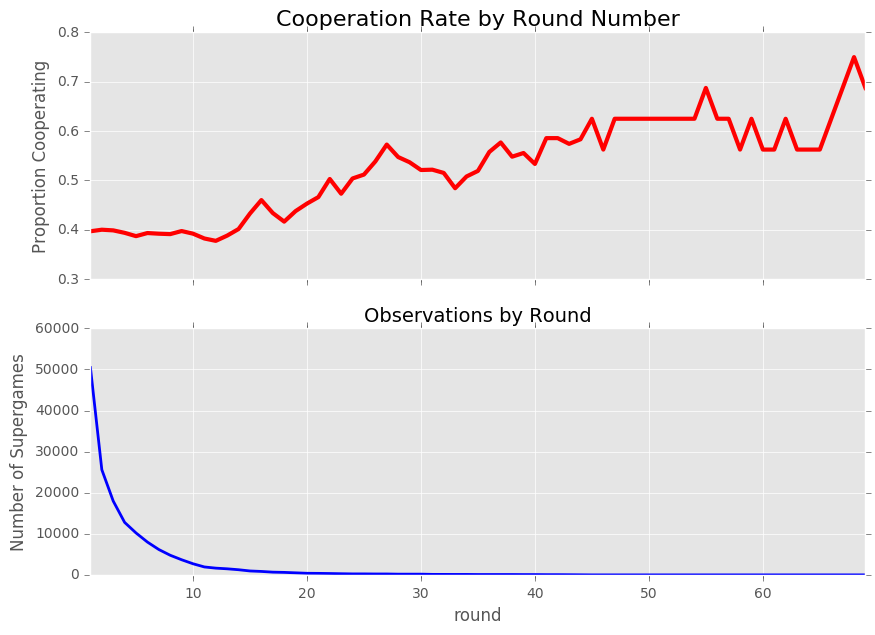

In [14]:
plt.style.use('ggplot')      # styles the graphs similar to ggplot package for R

fig1, ax1 = plt.subplots(2,  # create a two-graph figure with a shared x-axis
                        sharex = True,
                        figsize = (10,7))

# add titles and labels and adjust line thickness and font size
ax1[0].set_ylim(.3,.8)
ax1[0].set_title('Cooperation Rate by Round Number', fontsize = 16, loc = 'center')
ax1[1].set_title('Observations by Round', fontsize = 14, loc = 'center')
ax1[1].set_xlabel('Round', fontsize = 12)
ax1[0].set_ylabel('Proportion Cooperating', fontsize = 12)
ax1[1].set_ylabel('Number of Supergames', fontsize = 12)

# plot cooperation rate by round in thick red across the top panel
coop[['round','cooperate']].groupby('round').mean().plot(ax = ax1[0], 
                                                        kind = 'line',
                                                        color = 'red',
                                                        linewidth = 3,
                                                        legend = False)
    # we use grouping and the mean() command here so the average of the binary
    # 1 and 0 values for 'cooperate' gives us the cooperation rate across the sample

# using the count function, we show the number of supergames that reach each round, and
# thus the number of observations used in the calculation of each mean
coop[['round','cooperate']].groupby('round').count().plot(ax = ax1[1],
                                                         legend = False,
                                                         color = 'blue',
                                                         linewidth = 2)

The upper panel of the figure above charts the cooperation rate grouped by round of a given supergame. It seems to indicate that simply **playing repeatedly** and gaining experience will increase the rate of cooperation over time, regardless of the factors $\delta$, l and g, which we plan to investigate!

There are at least three major problems with this approach, and I present the figure above not to argue experience alone increases cooperation, but to justify focusing only on round 1 observations, which Frechette and Bo do (as will I for the rest of this investigation). These issues include:
1. The sample size rapidly diminishes and thus becomes less accurate as we increase the number of rounds, as the overwhelming majority of supergames end by round 10 (demonstrated by the lower panel). The fact that the cooperation rate across these first tens rounds containing the most observations is essentially constant calls the later trend into question.
2. There is a bias in terms of which observations make it to later rounds, as $\delta$ directly detemines the probability a given round of a supergame will be reached. Since the likelihood of interacting again is hypothesized to be a determinant of cooperative behavior, it is likely the positive round-cooperation relationship is the result of games with lower $\delta$ being progressively removed from the sample as round number increases.
3. Finally in all rounds other than round 1, players have also gathered information about and experience interacting with their partners in previous rounds. This makes it difficult to directly compare these choices and say they are the result of $\delta$, l and g.

Furthermore, if continued experience playing the dilemma increased cooperation rates, we should also expect to see an upward trend in cooperation across successive supergames (which also represent increasing experience), graphed below. However, the relationship appears noisy and erratic, with a slight upward trend for 20 supergames and a sharp downturn over the next 30. This lack of consistency supports the hypothesis that differences in $\delta$ are causing the earlier relationship between round and cooperation. Hence, we will conduct the rest of our analysis with only round 1 observations.

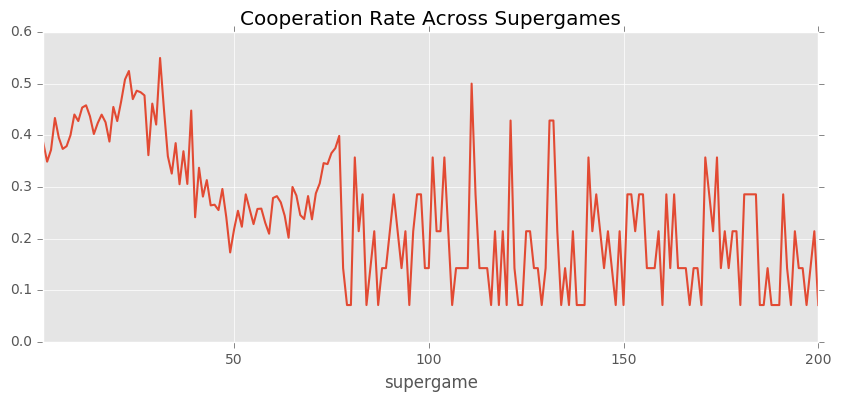

In [15]:
# we again use mean() and grouping, this time by supergame, to show the rate of cooperative actions in the 
# first round in each successive supergame
coop[['supergame','cooperate']].groupby('supergame').mean().plot(figsize = (10,4),
                                                                title = 'Cooperation Rate Across Supergames',
                                                                legend = False,
                                                                grid = True,
                                                                linewidth=1.5)

We creat the dataFrame `coop1`, the new subset of our original data filtered to include only round 1 observations, with which we will work for the rest of this investigation; the output of the shape command tells us that even with this filtering we retain 50,458 observations, approximately a third of the total dataset.

In [16]:
# the new DataFrame is set to contain all observations where round = 1, and subsequently drops
# the round variable since it will be 1 in all cases
coop1 = coop[coop['round'] == 1].drop('round', axis = 1)
print(coop1.shape)
coop1.head()

(50458, 9)


,paper,supergame,g,l,$\delta$,Subgame Perfect,Risk Dominant,sizeBAD,cooperate
0,Andreoni and Miller 1993,1,1.666667,1.333333,0.0,0,0,1.0,1
1,Andreoni and Miller 1993,2,1.666667,1.333333,0.0,0,0,1.0,0
2,Andreoni and Miller 1993,3,1.666667,1.333333,0.0,0,0,1.0,0
3,Andreoni and Miller 1993,4,1.666667,1.333333,0.0,0,0,1.0,0
4,Andreoni and Miller 1993,5,1.666667,1.333333,0.0,0,0,1.0,0


## Discount Rate $\delta$ and Cooperation

As previously discussed, the probability of a supergame continuing into the future is hypothesized to have a positive relationship to cooperation rates. One reason for this could be that players hope to elicit cooperative behavior from their partner in future rounds by being cooperative now.

The test this idea, we group our data set by the value of $\delta$ under which the player made their decision to cooperative or defect. Before graphing, we also quickly get an idea of the range and number of observations at each value of $\delta$ we're working with.

In [17]:
coop1[['$\delta$', 'cooperate']].groupby('$\delta$').count()

,cooperate
$\delta$,
0.000,11368
0.500,16088
0.750,18136
0.800,720
0.875,716
0.900,3210
0.950,220


The table above shows us there are seven values of $\delta$ for which our data set contains observations, and gives the number of observations at each level. The values range from 0% up to 95%, with a sizable number of observations at each value included in the data set. That said, there are far, far more observations at $\delta = 0.00, 0.50,$ and $0.75$, than at the other four values. This will be helpful to keep in mind in a moment.

Below we graph round 1 cooperation rates by the continuation probability $\delta$ of the treatment.

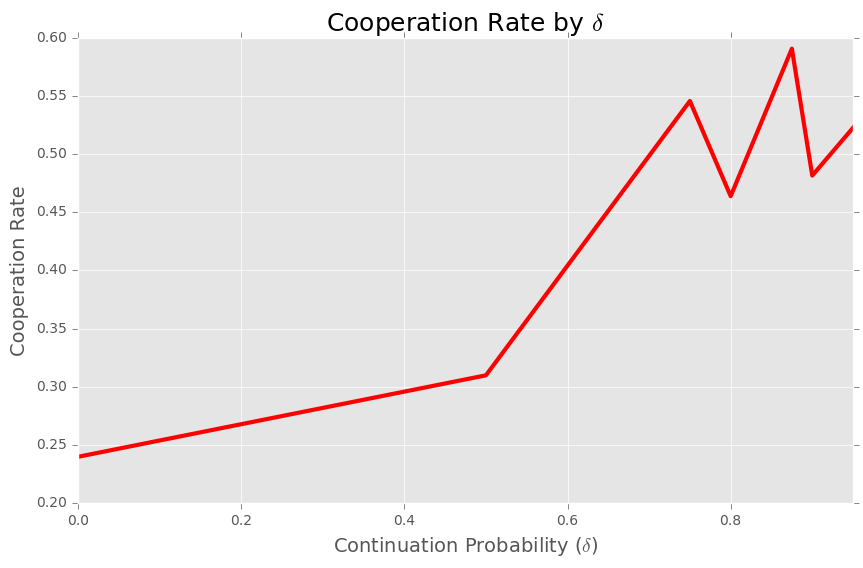

In [18]:
# create the figure
fig2, ax2 = plt.subplots(figsize = (10,6))

# group by the seven delta values and plot the cooperation rate
coop1[['$\delta$','cooperate']].groupby('$\delta$').mean().plot(ax = ax2, 
                                                            kind = 'line',
                                                            color = 'red',
                                                            legend = False,
                                                            linewidth = 3)

# add titles and axis labels
ax2.set_title('Cooperation Rate by $\delta$', fontsize = 18, loc = 'center')
ax2.set_xlabel('Continuation Probability ($\delta$)', fontsize = 14)
ax2.set_ylabel('Cooperation Rate', fontsize = 14)

There are two significant observations we can make from this graph:
1. Even in one shot prisoner's dilemmas ($\delta = 0$ on the graph), there is a cooperation rate significantly above zero (about 24%). This violates the predictions of game theory but is in line with past experiments and observations. Some degree of other-regarding preferences, altruism or preference for fairness or equality are suggested as possible explanations, none of which would be captured by the payoffs in the matrix displayed earlier.
2. There is a very clear and dramatic upward trend in cooperation as $\delta$ rises, from 24% up to nearly 60% when $\delta = 0.875$. This provides evidence in favor of our hypothesis.

The relationship appears to become more erratic or noisy at the upper values of $\delta$, but remember we noted that some these values had significantly fewer observations. If we regraph just the three values with more than 10,000 observations, the pattern looks even more clear.

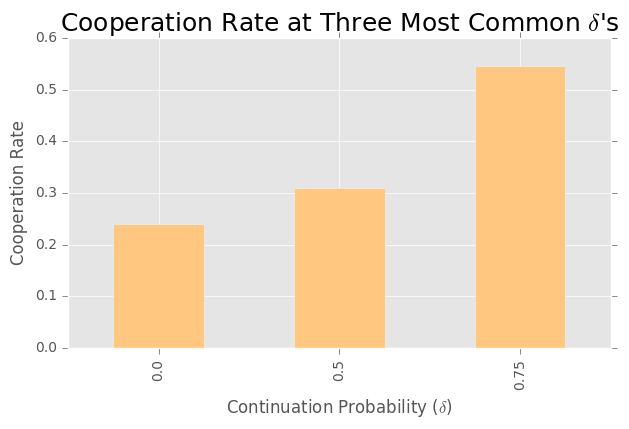

In [19]:
# create a dataFrame containing the subset of coop 1 for which delta is 0, 0.5 or 0.75
coop1filtered = coop1[coop1['$\delta$'] == 0.0]
for addMe in [0.5, 0.75]:
    coop1filtered = pd.concat([coop1filtered, coop1[coop1['$\delta$'] == addMe]])

# remove all unnecessary columns from the filtered dataFrame
coop1filtered = coop1filtered[['$\delta$', 'cooperate']]

# create the figure
fig3, ax3 = plt.subplots(figsize = (7,4))

coop1filtered.groupby('$\delta$').mean().plot(ax = ax3,
                                              kind = 'bar',
                                              colormap = 'copper_r',
                                              legend = False)

# add title and axis labels
ax3.set_title("Cooperation Rate at Three Most Common $\delta$'s", fontsize = 18)
ax3.set_xlabel('Continuation Probability ($\delta$)', fontsize = 12)
ax3.set_ylabel('Cooperation Rate', fontsize = 12)

Hence, we can safely conclude $\delta$ has a sizeable effect on a player's propensity to cooperate and is a major determinant of outcomes. This discovery is in alignment with Frechette and Bo's conclusions and the academic literature on prisoner's dilemmas more generally.

## Alternative Measures of the 'Difficulty of Cooperation'



While we've established continuation probability $\delta$ as a significant determinant of cooperative outcomes, thus far we have ignored differences in the size of the temptation to defect and potential loss of being defected on, measured by **g** and **l**. Our results have been promising, but unlike game theoretic models — which predict unambiguous 0% or 100% cooperation rates in any given situation — there remains considerable noise to be explained in our data, as evidenced by the fact that we see a mixture of cooperation and defection in all cases. If we found a more complete measure that predicted where more agents choose cooperation versus defection, this would represent an improvement in our understanding of the determinants of cooperation.

Frechette and Bo consider three more complex indices for measuring the "difficulty of cooperation", that is, the tendency for the situational factors captured by **g** and **l** to facilitate or hinder cooperative outcomes. We outline how each of the three measures is constructed and its interpretation, and then test their effectiveness below.

### 1. Shadow of the Future
The first measure we consider uses only a comparison of **g** and $\delta$ to determine the 'shadow of the future', which we can understand as the degree to which the attractiveness of the temptation payoff (captured by **g**) is overcome by the possibility of long-term gains achieved through cooperation. Perhaps surprisingly, it can be shown mathematically that this is the method that purely rational agents would use to calculation the subgame perfect equilibrium strategy. The minimum $\delta$ needed to make cooperation an equilibrium for any value of **g** is calculated as:

\\[ \delta^{SPE} = \frac{g}{1 + g} \\] 

To create a continuous variable across which we can plot cooperation rates for any values of $\delta$ and **g**, we rearrange the equation above to create our *SPE Index*.

\\[ SPE\,\, Index = \delta - \frac{g}{1 + g} \\]

We have constructed this index so that *SPE Index* $ = 0$ is a threshold above which game theory predicts cooperation, and below which it predicts defection. At this point we create a new column of our dataFrame containing the SPE Index.

In [20]:
# calculate the new column SPE Index using the values of g and delta already in the DataFrame
# and diplay the updated data set.
coop1['SPE Index'] = coop1['$\delta$'] -  (coop1['g'] / (1 + coop1['g']))
coop1.head()

,paper,supergame,g,l,$\delta$,Subgame Perfect,Risk Dominant,sizeBAD,cooperate,SPE Index
0,Andreoni and Miller 1993,1,1.666667,1.333333,0.0,0,0,1.0,1,-0.625
1,Andreoni and Miller 1993,2,1.666667,1.333333,0.0,0,0,1.0,0,-0.625
2,Andreoni and Miller 1993,3,1.666667,1.333333,0.0,0,0,1.0,0,-0.625
3,Andreoni and Miller 1993,4,1.666667,1.333333,0.0,0,0,1.0,0,-0.625
4,Andreoni and Miller 1993,5,1.666667,1.333333,0.0,0,0,1.0,0,-0.625


### 2. Risk Sensitive Index
Next we consider an index that incorporates both the gain from defection **g** and the potential loss of being defected on **l**. This index corresponds to the theory of risk dominance as a predictor of cooperative decisions discussed earlier; Frechette and Bo acknowledge [Roth and Murnighan](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.190.1687&rep=rep1&type=pdf)'s 1978 paper as the first to propose this index, shown below. We'll refer to it as the *Risk Dominance (RD) Index*.

\\[ RD\,\, Index = \delta - \frac{1 + g}{1 + l}  \\]

Much like our previous index is related to the subgame perfect equilibrium prediction, *RD Index *$= 0$ is the risk dominant threshold for the prisoner's dilemma game, such that greater values should anticipate higher cooperation rates. Below we calculate a column for our "RD Index" and add it to the dataFrame.

In [21]:
# calculate the new column RD Index using the values of g, l and delta already in 
# the DataFrame and diplay the updated data set.
coop1['RD Index'] = coop1['$\delta$'] - (1 + coop1['g']) / (1 + coop1['l'])
coop1.head()

,paper,supergame,g,l,$\delta$,Subgame Perfect,Risk Dominant,sizeBAD,cooperate,SPE Index,RD Index
0,Andreoni and Miller 1993,1,1.666667,1.333333,0.0,0,0,1.0,1,-0.625,-1.142857
1,Andreoni and Miller 1993,2,1.666667,1.333333,0.0,0,0,1.0,0,-0.625,-1.142857
2,Andreoni and Miller 1993,3,1.666667,1.333333,0.0,0,0,1.0,0,-0.625,-1.142857
3,Andreoni and Miller 1993,4,1.666667,1.333333,0.0,0,0,1.0,0,-0.625,-1.142857
4,Andreoni and Miller 1993,5,1.666667,1.333333,0.0,0,0,1.0,0,-0.625,-1.142857


### 3. Basin of Attraction to Defect
Finally, Frechette and Bo calculate possibly the most nuanced measure of the three, referred to as the basin of attraction to defect. Understood intuitively, the size of the basin represents a sort of gravity or 'pull' towards defection given the relative payoffs of the game. The measure incorporates elements of both the subgame perfect calulation in index (1) and risk concerns in index (2). The size of the basin of attraction to defect (or *BAD*) is calculated as:

\\[ BAD\,\, Index = \begin{cases} 1 & \delta < \frac{g}{1 + g} \\ \frac{(1 - \delta)l}{(1 - (1 - \delta)(1 + g - l))} & \text{otherwise} \end{cases} \\]

Looking at the piecewise conditions, one can see the size of the basin is taken to be 1 when cooperating is not subgame perfect (we can think of this as a 100% attraction to defect). Otherwise, the size of the basin is rising in **g** and **l**, and falling in $\delta$. A basin of defection *BAD *$= 0.5$ corresponds to the risk dominant threshold outlined above. The data set already has the variable **SizeBAD** for the BAD Index, so there is no need to calculate it ourselves.

We now graph cooperation rates against all three indices, and bar graphs showing cooperation rates on either side of the relevant threshold for all three measures.

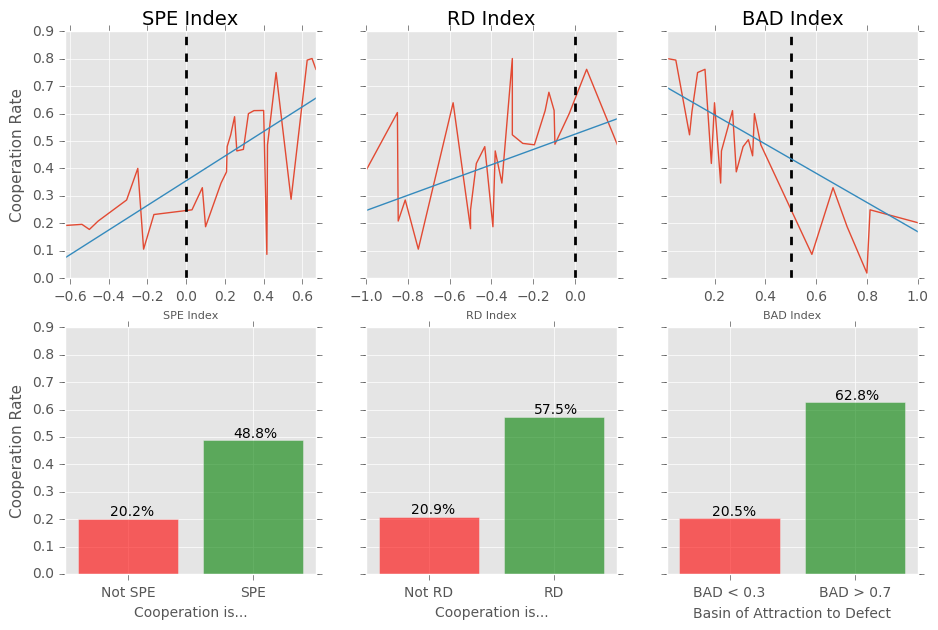

In [22]:
# create the 6 subplot figure
fig4, ax4 = plt.subplots(nrows = 2, ncols = 3, figsize = (11, 7), sharey = True)

# graph cooperation rates against each of the three indices discussed in the top
# half of the figure in red
coop1[['SPE Index', 'cooperate']].groupby('SPE Index').mean().plot(ax = ax4[0][0],
                                                                  legend = False,
                                                                  ylim = (0,0.9))

coop1[['RD Index', 'cooperate']].groupby('RD Index').mean().plot(ax = ax4[0][1],
                                                                  legend = False,
                                                                  xlim = (-1,0.2))

coop1[['sizeBAD', 'cooperate']].groupby('sizeBAD').mean().plot(ax = ax4[0][2],
                                                                  legend = False)

# graph verticle dotted lines at the subgame perfect equilibrium or risk dominant threshold
# for each of the three indices
ax4[0][0].axvline(color = 'k', linewidth = 2, linestyle = '--')
ax4[0][1].axvline(color = 'k', linewidth = 2, linestyle = '--')
ax4[0][2].axvline(color = 'k', linewidth = 2, x = 0.5, linestyle = '--')

# fit the linear regression for each of the three indices
mSPE, bSPE = np.polyfit(coop1['SPE Index'], coop1['cooperate'], 1)
mRD, bRD = np.polyfit(coop1['RD Index'], coop1['cooperate'], 1)
mBAD, bBAD = np.polyfit(coop1['sizeBAD'], coop1['cooperate'], 1)

# graph the best fit lines in blue
ax4[0][0].plot((-1, 1), (bSPE - mSPE, bSPE + mSPE))
ax4[0][1].plot((-1, 1), (bRD - mRD, bRD + mRD))
ax4[0][2].plot((-1, 1), (bBAD - mBAD, bBAD + mBAD))

# title the three regression graphs
ax4[0][0].set_title('SPE Index', fontsize = 14)
ax4[0][1].set_title('RD Index', fontsize = 14)
ax4[0][2].set_title('BAD Index', fontsize = 14)

# add the x-axis labels and a common y-axis label
ax4[0][0].set_xlabel('SPE Index', fontsize = 8)
ax4[0][1].set_xlabel('RD Index', fontsize = 8)
ax4[0][2].set_xlabel('BAD Index', fontsize = 8)
ax4[0][0].set_ylabel('Cooperation Rate', fontsize = 11)

# calculate the cooperation rates divided by whether cooperation is or is not subgame perfect
coopSPEyes = coop1[coop1['Subgame Perfect'] == 1]
SPEyesRate = coopSPEyes['cooperate'].mean()
coopSPEno = coop1[coop1['Subgame Perfect'] == 0]
SPEnoRate = coopSPEno['cooperate'].mean()

# calculate the cooperation rates divided by whether cooperation is or is not risk dominant
coopRDyes = coop1[coop1['Risk Dominant'] == 1]
RDyesRate = coopRDyes['cooperate'].mean()
coopRDno = coop1[coop1['Risk Dominant'] == 0]
RDnoRate = coopRDno['cooperate'].mean()

# calculate the cooperation rates for BAD score noticeable to either side of the risk dominant
# threshold
coopBADyes = coop1[coop1['sizeBAD'] < 0.3]
BADyesRate = coopBADyes['cooperate'].mean()
coopBADno = coop1[coop1['sizeBAD'] > 0.7]
BADnoRate = coopBADno['cooperate'].mean()

# set bar width, bar opacity, and spacing for the three bar graphs
ind = np.arange(0.25, 1.0, 0.5)
width = 0.4
opacity = 0.6

# graph the cooperation rates based on whether cooperation was a subgame perfect equilibrium,
# risk dominant equilibrium, or had a high vs. low basin of attraction in the lower panels of
# the figure below the corresponding continuous graph
ax4[1][0].bar(ind,
             [SPEnoRate, SPEyesRate],
             width = width,
             tick_label = ['Not SPE', 'SPE'],
             color = ['r', 'g'],
             alpha = opacity)

ax4[1][1].bar(ind,
             [RDnoRate, RDyesRate],
             width = width,
             tick_label = ['Not RD', 'RD'],
             color = ['r', 'g'],
             alpha = opacity)

ax4[1][2].bar(ind,
             [BADnoRate, BADyesRate],
             width = width,
             tick_label = ['BAD < 0.3', 'BAD > 0.7'],
             color = ['r', 'g'],
             alpha = opacity)

# add labels to each bar with the cooperation rates
ax4[1][0].text(0.38, SPEnoRate + 0.01, '20.2%')
ax4[1][0].text(0.87, SPEyesRate + 0.01, '48.8%')
ax4[1][1].text(0.38, RDnoRate + 0.01, '20.9%')
ax4[1][1].text(0.87, RDyesRate + 0.01, '57.5%')
ax4[1][2].text(0.38, BADnoRate + 0.01, '20.5%')
ax4[1][2].text(0.87, BADyesRate + 0.01, '62.8%')

# center the bar graph labels under their respectives bars
ax4[1][0].set_xticks(ind + width/2)
ax4[1][1].set_xticks(ind + width/2)
ax4[1][2].set_xticks(ind + width/2)

# label the x-axes of the bar graphs and add a common y-axis label
ax4[1][0].set_xlabel("Cooperation is...", fontsize = 10)
ax4[1][1].set_xlabel("Cooperation is...", fontsize = 10)
ax4[1][2].set_xlabel("Basin of Attraction to Defect", fontsize = 10)
ax4[1][0].set_ylabel("Cooperation Rate", fontsize = 11)

The upper panels of the figure above graph cooperation rates across all possible values of the three indices we constructed. The red lines, which chart cooperation rates at each specific value, exhibit significant variation because there are a large number of individual values each index takes. This means that the sample size at any given value may be relatively small. However, the blue line on each graph charts the regression line of best fit for all 50,000+ observations and shows that all three indices are significant predictors of cooperation rates.

As expected, cooperation rates rise with higher SPE Indices and RD Indices; the greater slope on the SPE index suggests it may be a slightly better predictor, but the difference does not appear large and it is clear both contribute valuable additional information compared to $\delta$ alone.

The basin of attraction to defect (BAD) Index also does an impressive job predicting cooperation rates, with cooperation falling as the size of the basin increases, as predicted. Furthermore, cooperation rates exhibit a sharp drop from which they never recover as the basin size crosses the risk dominant threshold - an additional sign of strength that supports the hypothesis used in developing the index.

The lower panels of the figure show the differentiating power of the three indices even more clearly by comparing cooperation rates on either side of the relevant theoretical threshold for each index. Cooperation rates are 48.8% when it is a subgame perfect equilibrium strategy versus just 20.2% when it is not; this shows the sub game perfect equilibrium concept has merit even if it far from a perfect indicator. The risk dominant equilibrium concept is similarly affirmed, with more than a 35% different in cooperation rates.

For the basin of attraction index, we compare the groups for which the basin of attraction is either less than 0.3 (very small) or greater than 0.7 (quite large). By eliminating those observations very close to the risk dominance threshold, we can see if the size of the basin provides better information than the simple binary "RD/Not RD" and "SPE/Not SPE" charts. Indeed, the size of the basin does seem to contribute marginally more information, resulting in the largest gap in cooperation between the two groups (42.3%). 

## Conclusion

The results show that theoretical predictions of cooperation are far from perfect, but can give us significant and effective predictors of the *likelihood* of cooperation in repeated prisoner's dilemmas. The continuation probability $\delta$ alone is already a significant predictor of cooperation rates, but the three indices investigated can provided even more information.

Both the SPE and RD indices exhibit large predictive power when used as regressors for a prediction model of cooperation (as shown by the trend lines we plotted). Additionally, the basin of attraction to defect indices, which combines elements of the subgame perfect and risk dominance index, seems to be a particularly effective predictor. This suggests there is merit to each of the two predictor theories for the prisoner's dilemma, and future researchers are well supported to use them in designing and forming hypotheses for future experiments.